## Fixed Random Seed

In [34]:
import numpy as np
import random
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import optuna
from prettytable import PrettyTable
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.base import clone, BaseEstimator, TransformerMixin
from category_encoders import TargetEncoder
from catboost import CatBoostRegressor
import statsmodels.api as sm

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

TARGET = "Income"

## 데이터 불러오기 및 확인

In [35]:
import pandas as pd

train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

display(train.head(3))
display(test.head(3))

,ID,Age,Gender,Education_Status,Employment_Status,Working_Week (Yearly),Industry_Status,Occupation_Status,Race,Hispanic_Origin,...,Citizenship,Birth_Country,Birth_Country (Father),Birth_Country (Mother),Tax_Status,Gains,Losses,Dividends,Income_Status,Income
0,TRAIN_00000,63,M,Middle (7-8),Full-Time,4,Social Services,Services,White,All other,...,Native,US,US,US,Nonfiler,0,0,0,Unknown,425
1,TRAIN_00001,37,M,Associates degree (Vocational),Full-Time,52,Entertainment,Services,White,All other,...,Native,US,US,US,Single,0,0,0,Under Median,0
2,TRAIN_00002,58,F,High graduate,Full-Time,52,Manufacturing (Non-durable),Admin Support (include Clerical),Black,All other,...,Native,US,US,US,Married Filling Jointly both under 65 (MFJ),3411,0,0,Under Median,860


,ID,Age,Gender,Education_Status,Employment_Status,Working_Week (Yearly),Industry_Status,Occupation_Status,Race,Hispanic_Origin,...,Household_Summary,Citizenship,Birth_Country,Birth_Country (Father),Birth_Country (Mother),Tax_Status,Gains,Losses,Dividends,Income_Status
0,TEST_0000,79,M,High Junior,Children or Armed Forces,0,Not in universe or children,Unknown,White,All other,...,Householder,Native,US,Unknown,Unknown,Single,0,0,0,Under Median
1,TEST_0001,47,M,Elementary (5-6),Children or Armed Forces,0,Not in universe or children,Unknown,White,Other Spanish,...,Child 18 or older,Native,US,US,US,Nonfiler,0,0,0,Under Median
2,TEST_0002,18,F,High Junior,Children or Armed Forces,52,Retail,Services,White,All other,...,Child 18 or older,Native,US,US,US,Single,0,0,0,Under Median


In [36]:
train.describe()

,Age,Working_Week (Yearly),Gains,Losses,Dividends,Income
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,35.632500,34.943050,383.129500,40.202150,123.451450,554.565250
std,17.994414,22.254592,4144.247487,279.182677,1206.949429,701.553155
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,23.000000,7.000000,0.000000,0.000000,0.000000,0.000000
50%,34.000000,52.000000,0.000000,0.000000,0.000000,500.000000
75%,47.000000,52.000000,0.000000,0.000000,0.000000,875.000000
max,90.000000,52.000000,99999.000000,4356.000000,45000.000000,9999.000000


In [37]:
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   ID                      20000 non-null  object
 1   Age                     20000 non-null  int64 
 2   Gender                  20000 non-null  object
 3   Education_Status        20000 non-null  object
 4   Employment_Status       20000 non-null  object
 5   Working_Week (Yearly)   20000 non-null  int64 
 6   Industry_Status         20000 non-null  object
 7   Occupation_Status       20000 non-null  object
 8   Race                    20000 non-null  object
 9   Hispanic_Origin         20000 non-null  object
 10  Martial_Status          20000 non-null  object
 11  Household_Status        20000 non-null  object
 12  Household_Summary       20000 non-null  object
 13  Citizenship             20000 non-null  object
 14  Birth_Country           20000 non-null  object
 15  Bi

In [38]:
for col in train[['Gender', 'Education_Status', 'Employment_Status', 'Working_Week (Yearly)', 'Industry_Status', 'Occupation_Status', 'Race', 'Hispanic_Origin', 'Martial_Status','Household_Status','Household_Summary','Citizenship','Birth_Country','Birth_Country (Father)','Birth_Country (Mother)','Tax_Status','Gains','Losses','Dividends','Income_Status','Income']].columns:

    print(train[col].value_counts())

F    10472
M     9528
Name: Gender, dtype: int64
High graduate                     6494
College                           3794
Children                          2208
Bachelors degree                  1956
High Junior                        820
High Sophomore                     799
Associates degree (Vocational)     741
Associates degree (Academic)       609
High Freshman                      555
Middle (7-8)                       548
Masters degree                     505
Elementary (5-6)                   317
High Senior                        242
Elementary (1-4)                   150
Professional degree                111
Doctorate degree                    87
Kindergarten                        64
Name: Education_Status, dtype: int64
Children or Armed Forces         11142
Full-Time                         6588
Not Working                       1221
Choice Part-Time                   593
Part-Time (Usually Part-Time)      158
Seeking Full-Time                  121
Part-Time (Usuall

In [39]:
class ColumnEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, cols):
        self.cols = cols
        
    def fit_transform(self, X, y=None):
        self.encoders = {}
        for col in self.cols:
            le = TargetEncoder()
            X[col] = le.fit_transform(X[col], y)
            self.encoders[col] = le
        return X
    
    def transform(self, X):
        for col in self.cols:
            X[col] = self.encoders[col].transform(X[col])
        return X

## 데이터 전처리 1 : 학습 및 추론 데이터 설정

<Axes: xlabel='Income', ylabel='Count'>

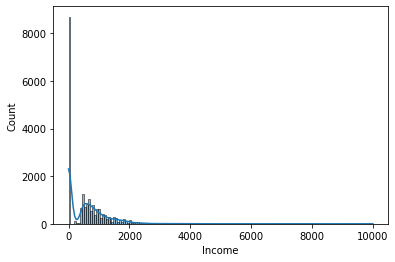

In [40]:
sns.histplot(train['Income'], linewidth=0.5, kde=True)

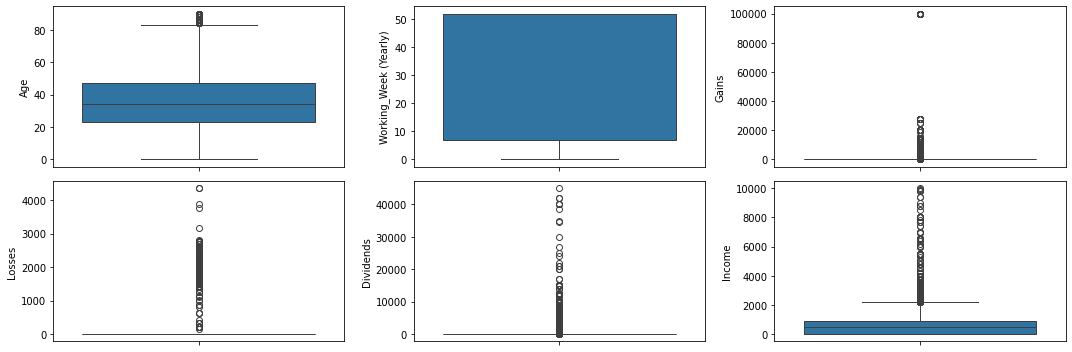

In [41]:
# 이상치 확인
fig, axes = plt.subplots(2, 3, figsize=(15, 5))

sns.boxplot(data=train, y='Age', ax=axes[0][0])
sns.boxplot(data=train, y='Working_Week (Yearly)', ax=axes[0][1])
sns.boxplot(data=train, y='Gains', ax=axes[0][2])
sns.boxplot(data=train, y='Losses', ax=axes[1][0])
sns.boxplot(data=train, y='Dividends', ax=axes[1][1])
sns.boxplot(data=train, y='Income', ax=axes[1][2])

plt.tight_layout()
plt.show()


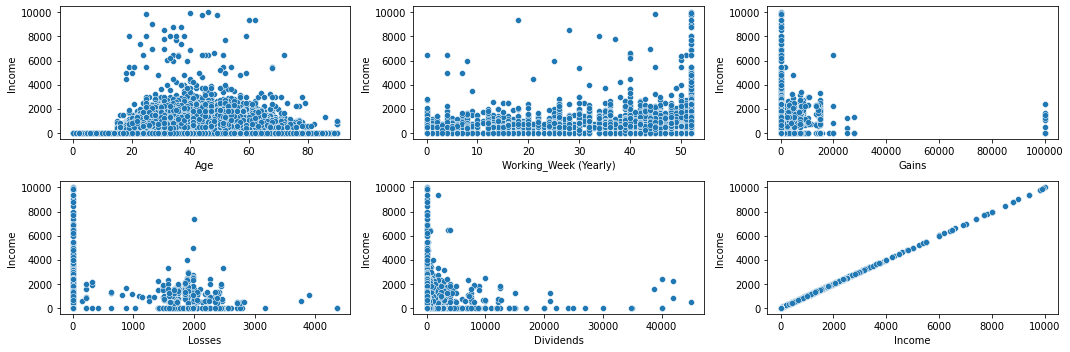

In [42]:
# 이상치 확인
fig, axes = plt.subplots(2, 3, figsize=(15, 5))

sns.scatterplot(data=train, y='Income', x='Age', ax=axes[0][0])
sns.scatterplot(data=train, y='Income', x='Working_Week (Yearly)', ax=axes[0][1])
sns.scatterplot(data=train, y='Income', x='Gains', ax=axes[0][2])
sns.scatterplot(data=train, y='Income', x='Losses', ax=axes[1][0])
sns.scatterplot(data=train, y='Income', x='Dividends', ax=axes[1][1])
sns.scatterplot(data=train, y='Income', x='Income', ax=axes[1][2])

plt.tight_layout()
plt.show()


<ipython-input-43-6785f3224427>:10: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
<ipython-input-43-6785f3224427>:10: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
<ipython-input-43-6785f3224427>:10: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
<ipython-input-43-6785f3224427>:10: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
<ipython-input-43-6785f3224427>:10: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
<ipython-input-43-6785f3224427>:10: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
<ipython-input-43-6785f3224427>:10: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
<ipython-input-43-6785f3224427>:10: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
<ipython-input-43-6785f3224427>:10: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
<ipython-input-43-6

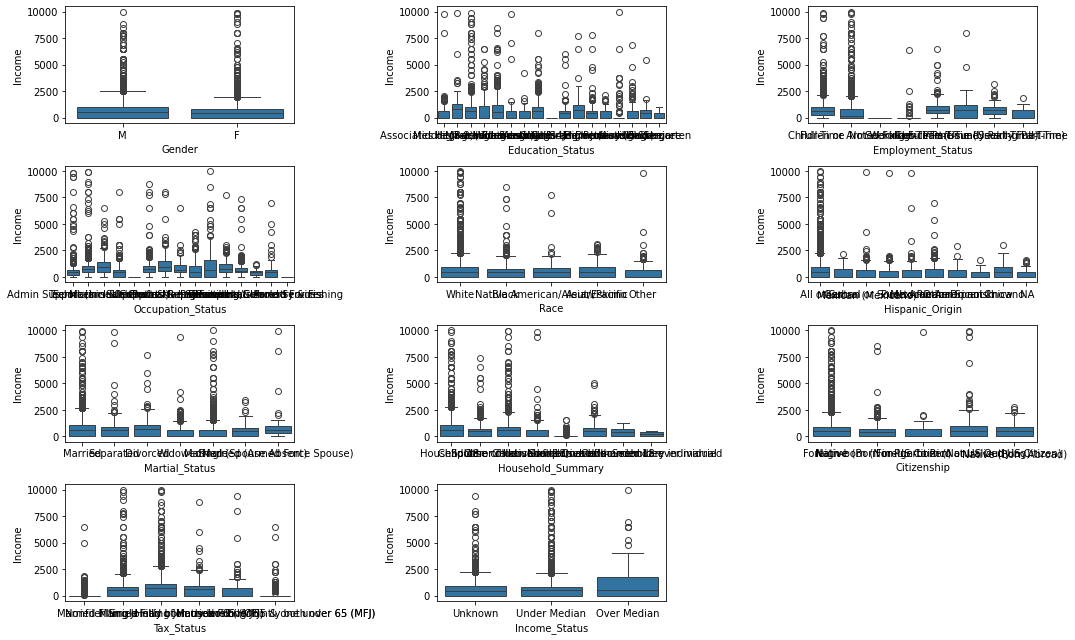

In [43]:
# train에서 컬럼의 unique한 값의 개수가 20개 이하인 컬럼만 선택
selected_cols = [col for col in train.columns if len(train[col].unique()) <= 20]
# target과의 관계를 살펴보기 위해, target을 분리하여 데이터를 분석
train_eda = train[selected_cols + [TARGET]].copy()

plt.figure(figsize=(15, 9))
for i, col in enumerate(selected_cols):
    plt.subplot(4, 3, i+1)
    sns.boxplot(x=col, y=TARGET, data=train_eda)
    plt.tight_layout()

In [44]:
def prettify_df(df):
    table = PrettyTable()
    table.field_names = df.columns

    for row in df.values:
        table.add_row(row)
    print(table)

In [45]:
# Train Data
print("Train Data")
print(f"Total number of rows: {len(train)}")
print(f"Total number of columns: {train.shape[1]}\n")

# Test Data
print("Test Data")
print(f"Total number of rows: {len(test)}")
print(f"Total number of columns:{test.shape[1]}")

Train Data
Total number of rows: 20000
Total number of columns: 23

Test Data
Total number of rows: 10000
Total number of columns:22


### Income 예측이 음수 값인 경우 0으로 변환

### Income = 0 인 경우
- Industry_Status : Not in universe
- Occupation_Status : Unknown
- Employment_Status : Not Working
- Education_Status : Children

In [46]:
skf = StratifiedKFold(n_splits=5)

def cross_val_model(train, estimators,cv = skf, verbose = True):
    X = train.copy()
    y = X.pop(TARGET)

    test_predictions = np.zeros((len(test)))

    val_scores = []
    for fold, (train_ind, valid_ind) in enumerate(skf.split(X,y)):
        model = clone(estimators)
        
        X_train, y_train = X.iloc[train_ind], y.iloc[train_ind]
        X_valid, y_valid = X.iloc[valid_ind], y.iloc[valid_ind]
        
        model.fit(X_train, y_train)

        if verbose:
            print("-" * 100)
            print(f"Fold: {fold}")

            y_preds_t = model.predict(X_train)
            y_preds_t[y_preds_t < 0] = 0
            
            y_preds_v = model.predict(X_valid)
            y_preds_v[y_preds_v < 0] = 0

            print(f"Train Accuracy Score:-{mean_squared_error(y_train, y_preds_t, squared=False)}")
            print(f"Valid Accuracy Score:-{mean_squared_error(y_valid, y_preds_v, squared=False)}")
            print("-" * 100)

        test_predictions += model.predict(test) / 5
        y_preds = model.predict(X_valid)
        y_preds[y_preds < 0] = 0
        y_preds[X_valid['Industry_Status'] == 'Not in universe'] = 0
        y_preds[X_valid['Occupation_Status'] == 'Unknown'] = 0
        y_preds[X_valid['Employment_Status'] == 'Not Working'] = 0
        y_preds[X_valid['Education_Status'] == 'Children'] = 0
        

        val_scores.append(mean_squared_error(y_valid,y_preds, squared=False))

    if verbose: 
        print(f"RMSE Score: {np.array(val_scores).mean()}")

    test_predictions[test_predictions < 0] = 0
    test_predictions[test['Industry_Status'] == 'Not in universe'] = 0
    test_predictions[test['Occupation_Status'] == 'Unknown'] = 0
    test_predictions[test['Employment_Status'] == 'Not Working'] = 0
    test_predictions[test['Education_Status'] == 'Children'] = 0
    
    return val_scores, test_predictions

In [47]:
# train.head()

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   ID                      20000 non-null  object
 1   Age                     20000 non-null  int64 
 2   Gender                  20000 non-null  object
 3   Education_Status        20000 non-null  object
 4   Employment_Status       20000 non-null  object
 5   Working_Week (Yearly)   20000 non-null  int64 
 6   Industry_Status         20000 non-null  object
 7   Occupation_Status       20000 non-null  object
 8   Race                    20000 non-null  object
 9   Hispanic_Origin         20000 non-null  object
 10  Martial_Status          20000 non-null  object
 11  Household_Status        20000 non-null  object
 12  Household_Summary       20000 non-null  object
 13  Citizenship             20000 non-null  object
 14  Birth_Country           20000 non-null  object
 15  Bi

In [48]:
# 불필요한 컬럼 제거 및 중복 데이터 제거
drop_cols = ['ID']
train.drop(drop_cols, axis = 1, inplace = True)
test.drop(drop_cols, axis = 1, inplace = True)

train = train.drop_duplicates()
train.reset_index(drop=True, inplace=True)

In [49]:
# ID
# Age
# Gender
# Education_Status
# Employment_Status
# Working_Week (Yearly)
# Industry_Status
# Occupation_Status
# Race
# Hispanic_Origin
# Martial_Status
# Household_Status
# Household_Summary
# Citizenship
# Birth_Country
# Birth_Country (Father)
# Birth_Country (Mother)
# Tax_Status
# Gains
# Losses
# Dividends
# Income_Status
# Income

In [50]:
for df in [train, test]:
    df['Working_Week_rate'] = df['Working_Week (Yearly)'] / 52

    df['Edu_Emp'] = df['Education_Status'] + '_' + df['Employment_Status']

    df['Ind_Occ'] = df['Industry_Status'] + '_' + df['Occupation_Status']

    df['Race_Hisp'] = df['Race'] + '_' + df['Hispanic_Origin']

    df['Tax_Income'] = df['Tax_Status'] + '_' + df['Income_Status']

    df['Birth_Country_F_M'] = df['Birth_Country (Father)'] + '_' + df['Birth_Country (Mother)']

    df['Age * Work%'] = df['Age'] * df['Working_Week_rate']
    
    df['log Gains'] = np.log(df['Gains']+1)

    df['log Losses'] = np.log(df['Losses']+1)

    df['log Dividends'] = np.log(df['Dividends']+1)
    

In [51]:
# null 및 고유 카운트 확인
train_copy = train.copy()
tmp = pd.DataFrame(index=train_copy.columns)
tmp['count'] = train_copy.count()
tmp['dtype'] = train_copy.dtypes
tmp['nunique'] = train_copy.nunique()
tmp['%nunique'] = (tmp['nunique']/len(train_copy))*100
tmp['%null'] = (train_copy.isnull().sum()/len(train_copy))*100
# tmp에서 column type이 object가 아닌 것의 최소를 구하기, column type이 object이면 'no'로 채움
tmp['min'] = [train_copy[col].min() if train_copy[col].dtype != 'object' else None for col in train_copy.columns]
tmp['max'] = [train_copy[col].max() if train_copy[col].dtype != 'object' else None for col in train_copy.columns]
tmp

tmp.reset_index(inplace=True)
tmp = tmp.rename(columns = {"index":"Column Name"})
tmp = tmp.round(3)
prettify_df(tmp)
del tmp, train_copy

+------------------------+-------+---------+---------+----------+-------+-----+---------+
|      Column Name       | count |  dtype  | nunique | %nunique | %null | min |   max   |
+------------------------+-------+---------+---------+----------+-------+-----+---------+
|          Age           | 18501 |  int64  |    91   |  0.492   |  0.0  | 0.0 |   90.0  |
|         Gender         | 18501 |  object |    2    |  0.011   |  0.0  | nan |   nan   |
|    Education_Status    | 18501 |  object |    17   |  0.092   |  0.0  | nan |   nan   |
|   Employment_Status    | 18501 |  object |    8    |  0.043   |  0.0  | nan |   nan   |
| Working_Week (Yearly)  | 18501 |  int64  |    53   |  0.286   |  0.0  | 0.0 |   52.0  |
|    Industry_Status     | 18501 |  object |    24   |   0.13   |  0.0  | nan |   nan   |
|   Occupation_Status    | 18501 |  object |    15   |  0.081   |  0.0  | nan |   nan   |
|          Race          | 18501 |  object |    5    |  0.027   |  0.0  | nan |   nan   |
|    Hispa

In [52]:
# column encoder
categorical_columns = train.select_dtypes(include=['object']).columns

train = train.copy()
ce = ColumnEncoder(categorical_columns)
train = ce.fit_transform(train, train[TARGET])
test = ce.transform(test)

In [53]:
# null 및 고유 카운트 확인
train_copy = train.copy()
tmp = pd.DataFrame(index=train_copy.columns)
tmp['count'] = train_copy.count()
tmp['dtype'] = train_copy.dtypes
tmp['nunique'] = train_copy.nunique()
tmp['%nunique'] = (tmp['nunique']/len(train_copy))*100
tmp['%null'] = (train_copy.isnull().sum()/len(train_copy))*100
# tmp에서 column type이 object가 아닌 것의 최소를 구하기, column type이 object이면 'no'로 채움
tmp['min'] = [train_copy[col].min() if train_copy[col].dtype != 'object' else None for col in train_copy.columns]
tmp['max'] = [train_copy[col].max() if train_copy[col].dtype != 'object' else None for col in train_copy.columns]
tmp

tmp.reset_index(inplace=True)
tmp = tmp.rename(columns = {"index":"Column Name"})
tmp = tmp.round(3)
prettify_df(tmp)
del tmp, train_copy

+------------------------+-------+---------+---------+----------+-------+---------+----------+
|      Column Name       | count |  dtype  | nunique | %nunique | %null |   min   |   max    |
+------------------------+-------+---------+---------+----------+-------+---------+----------+
|          Age           | 18501 |  int64  |    91   |  0.492   |  0.0  |   0.0   |   90.0   |
|         Gender         | 18501 | float64 |    2    |  0.011   |  0.0  | 531.231 |  673.93  |
|    Education_Status    | 18501 | float64 |    17   |  0.092   |  0.0  |   0.0   |  867.27  |
|   Employment_Status    | 18501 | float64 |    8    |  0.043   |  0.0  |   0.0   | 877.905  |
| Working_Week (Yearly)  | 18501 |  int64  |    53   |  0.286   |  0.0  |   0.0   |   52.0   |
|    Industry_Status     | 18501 | float64 |    24   |   0.13   |  0.0  |   0.0   | 1115.292 |
|   Occupation_Status    | 18501 | float64 |    15   |  0.081   |  0.0  |   0.0   | 1002.418 |
|          Race          | 18501 | float64 |    5 

In [ ]:
def objective(trial):
    params = {
        "iterations": 1000,
        "depth": trial.suggest_int("depth", 4, 15),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1.0),
        "random_strength": trial.suggest_float("random_strength", 1e-3, 1e-1, log=True),
        "border_count": trial.suggest_int("border_count", 1, 255),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-3, 1e2, log=True),
        "leaf_estimation_iterations": trial.suggest_int("leaf_estimation_iterations", 1, 10),
        "leaf_estimation_method": trial.suggest_categorical("leaf_estimation_method", ["Newton", "Gradient"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
        "grow_policy": trial.suggest_categorical("grow_policy", ["SymmetricTree", "Depthwise", "Lossguide"]),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        "one_hot_max_size": trial.suggest_int("one_hot_max_size", 0, 25),
        "random_state": 42,
        "verbose": 0,
        "loss_function": "RMSE",
    }
    
    model = make_pipeline(
        CatBoostRegressor(**params)
        )
    
    val_scores, _ = cross_val_model(train, model, verbose=False)
    return np.mean(val_scores)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=1000)

In [ ]:
best_params = study.best_params

best_params["random_state"] = 42
best_params["verbose"] = 0
best_params["iterations"] = 1000
best_params["loss_function"] = "RMSE"

CB = make_pipeline(
    CatBoostRegressor(**best_params)
    )

In [ ]:
print(best_params)

{'depth': 7, 'learning_rate': 0.017583538296520786, 'random_strength': 0.0010018857421937968, 'border_count': 106, 'l2_leaf_reg': 85.22284049359163, 'leaf_estimation_iterations': 3, 'leaf_estimation_method': 'Newton', 'bootstrap_type': 'Bayesian', 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 30, 'one_hot_max_size': 1, 'random_state': 42, 'verbose': 0, 'iterations': 1000, 'loss_function': 'RMSE'}


In [ ]:
# Train Catboost Model
_, test_predictions = cross_val_model(train, CB)

/home/sts07142/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


----------------------------------------------------------------------------------------------------
Fold: 0
Train Accuracy Score:-577.1093926139922
Valid Accuracy Score:-608.589639897628
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Fold: 1
Train Accuracy Score:-571.2772848740647
Valid Accuracy Score:-615.2232401917756
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Fold: 2
Train Accuracy Score:-578.6888247564334
Valid Accuracy Score:-588.5948629812012
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Fold: 3
Train Accuracy Score:-

In [ ]:
submission = pd.read_csv('./sample_submission.csv')
submission['Income'] = test_predictions

In [ ]:
submission.to_csv('./baseline_submission.csv', index=False)